\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

## (a) {-}

In [3]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = pd.read_csv('marketing.csv')

for col in X.columns:
    if col not in ['age', 'balance']:
        X[col] = X[col].astype("category")

X = pd.get_dummies(X).drop('y_no', axis='columns').rename(columns={'y_yes': 'y'})
y = X.pop('y')

X_tmp, X_final, y_tmp, y_final = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=10)

train_dm = xgb.DMatrix(X_train.values, y_train.values)
test_dm = xgb.DMatrix(X_test.values, y_test.values)

param = {'learning_rate': 0.3, 
         'max_depth': 6,
         'objective': 'binary:logistic', 
         'seed': 0, 
         'eval_metric': 'auc', 
        }

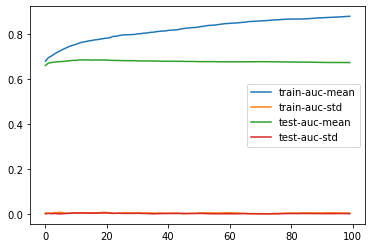

14

In [4]:
cvres = xgb.cv(param, train_dm, 100)
cvres.plot()
plt.show()
cvres['test-auc-mean'].argmax()

In [2]:
from sklearn.ensemble import RandomForestClassifier
import pickle, lzma

default_bst = xgb.train(param, train_dm, 14)
rf = RandomForestClassifier(n_estimators=500, oob_score=True).fit(X_train, y_train)

for i, fitted in enumerate([default_bst, rf]):
    with lzma.open(f'clf{i}.xz', 'wb') as f:
        f.write(pickle.dumps(fitted))

In [2]:
import lzma, pickle

with lzma.open('clf0.xz', 'rb') as f:
    default_bst = pickle.loads(f.read())

with lzma.open('clf1.xz', 'rb') as f:
    rf = pickle.loads(f.read())    

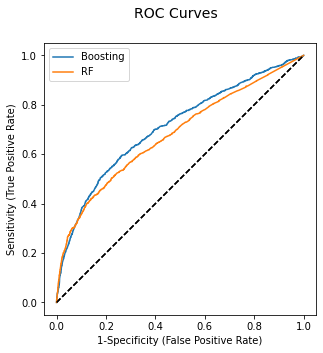

In [9]:
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt

predict_proba_bst = default_bst.predict(test_dm)
predict_proba_rf = rf.predict_proba(X_test)[:, 1]

predict_proba_map = {
    'Boosting': predict_proba_bst, 
    'RF': predict_proba_rf}

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for name, predict_proba in predict_proba_map.items():
    fpr, tpr, _ = roc_curve(y_test, predict_proba) 
    ax.plot(fpr, tpr, label=name)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set( aspect=1, 
            xlabel='1-Specificity (False Positive Rate)', 
            ylabel='Sensitivity (True Positive Rate)')
    
fig.suptitle('ROC Curves', fontsize=14)
plt.legend()
plt.show()

In [21]:
from pandas import DataFrame

threshold = 0.5

res = {key: [] for key, _ in predict_proba_map.items()}

for name, predict_proba in predict_proba_map.items():
    bestIdxSet = predict_proba.argsort()[-1000:]
    y_select = y_test.values[bestIdxSet]
    res[name].append(y_select.sum()/len(y_select))
    
    y_pred = predict_proba > threshold
    res[name].append(1 - accuracy_score(y_test, y_pred))
    
DataFrame(res, index=['Best 1000', 'Misclassification'])

,Boosting,RF
Best 1000,0.349000,0.347000
Misclassification,0.117452,0.126189


# 2. {-}

## (a) {-}

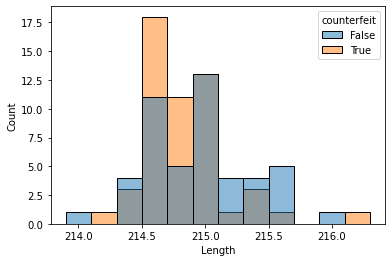

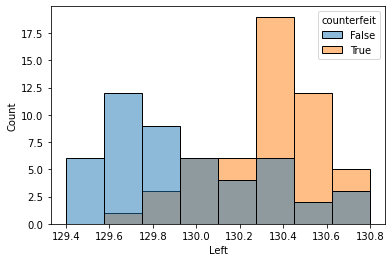

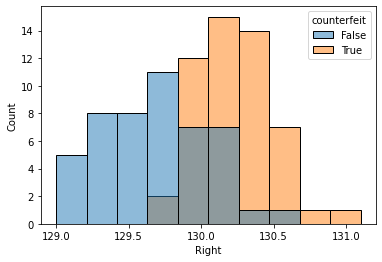

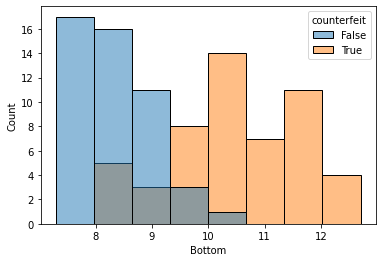

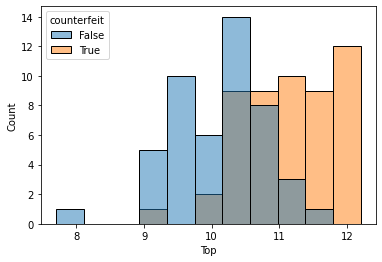

In [20]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X = pd.read_csv('banknote_measurements.csv', index_col=0)
y = (X.pop('counterfeit') == 'counterfeit')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

for col in X_test.columns:
    sns.histplot(data=X_test, x=col, hue=y_test)
    plt.show()

## (b) {-}

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from pandas import DataFrame

clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test)).ravel()

DataFrame([[tp, fp], [fn, tn]], columns=['True $Y$$=1$', 'True $Y$$=0$'], index=['Guess $Y$$=1$', 'Guess $Y$$=0$'])

,True $Y$$=1$,True $Y$$=0$
Guess $Y$$=1$,46,1
Guess $Y$$=0$,6,47


In [46]:
(fn + fp)/(tn + fp + fn + tp)

0.07

## (c) {-}

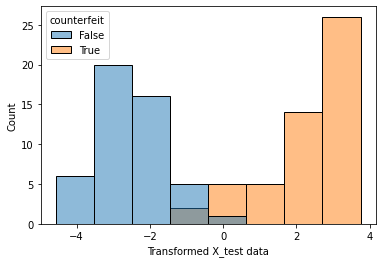

In [52]:
ax = sns.histplot(x=clf.transform(X_test).flatten(), hue=y_test)
ax.set(xlabel='Transformed X_test data')
plt.show()

# 3. {-}

## (a) {-}

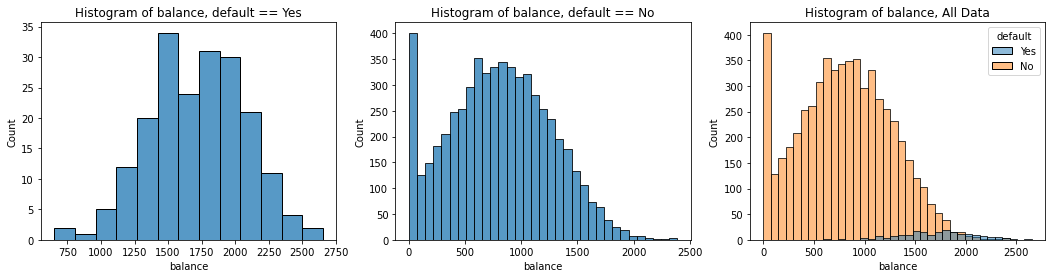

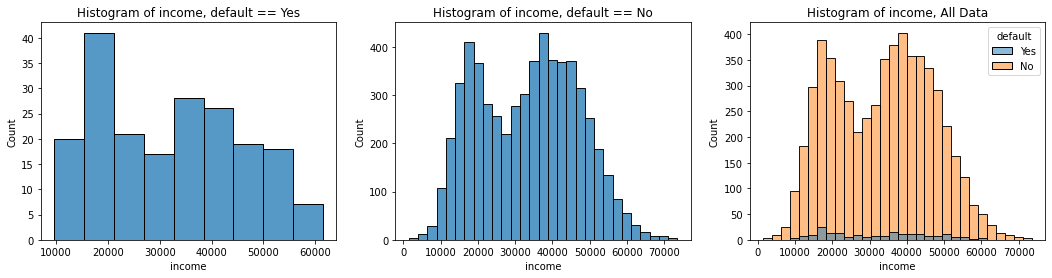

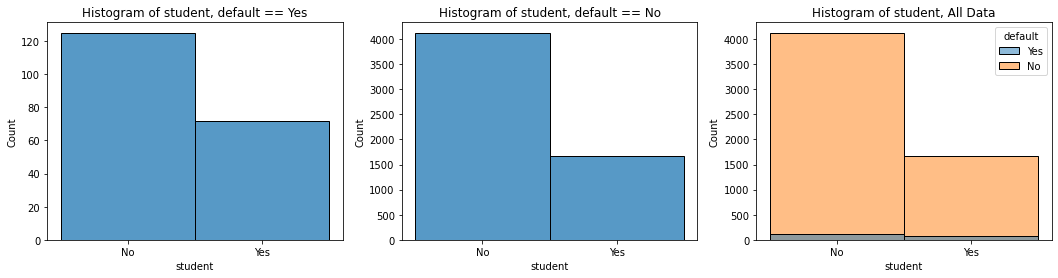

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

X_train = pd.read_csv('default_train.csv')
y_train = X_train.pop('default')

X_test = pd.read_csv('default_test.csv')
y_test = X_test.pop('default')

for col in ['balance', 'income', 'student']:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    sns.histplot(x=col, data=X_train[y_train=='Yes'], ax=ax1)
    sns.histplot(x=col, data=X_train[y_train=='No'], ax=ax2)
    sns.histplot(x=col, data=X_train, hue=y_train, ax=ax3)
    ax1.set(title=f'Histogram of {col}, default == Yes')
    ax2.set(title=f'Histogram of {col}, default == No')
    ax3.set(title=f'Histogram of {col}, All Data')
    plt.show()
    print()


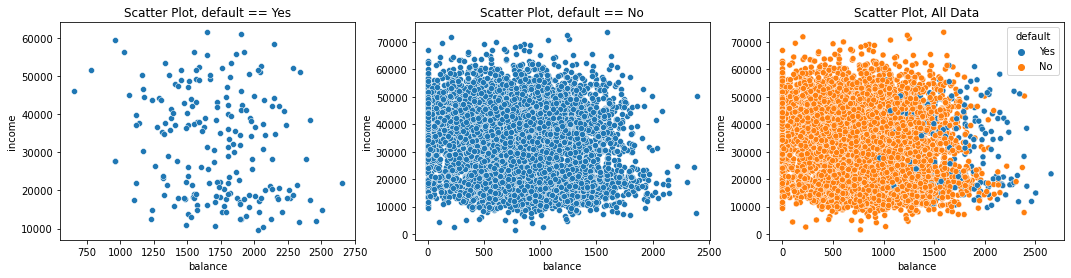

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
sns.scatterplot(x='balance', y='income', ax=ax1, data=X_train[y_train=='Yes'])
sns.scatterplot(x='balance', y='income', ax=ax2, data=X_train[y_train=='No'])
sns.scatterplot(x='balance', y='income', ax=ax3, data=X_train, hue=y_train)
ax1.set(title='Scatter Plot, default == Yes') 
ax2.set(title='Scatter Plot, default == No')
ax3.set(title='Scatter Plot, All Data')
plt.show()

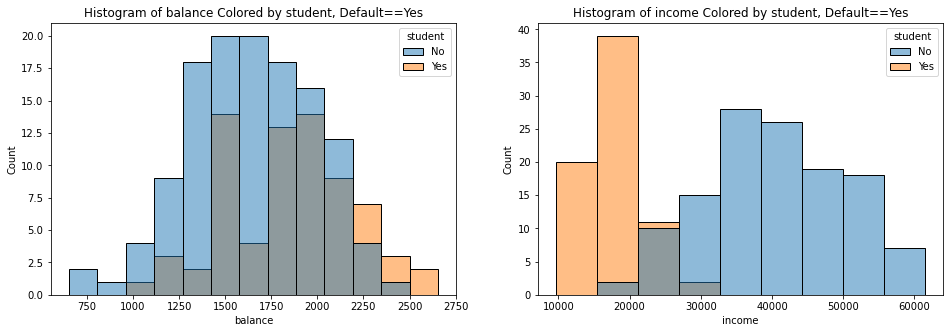

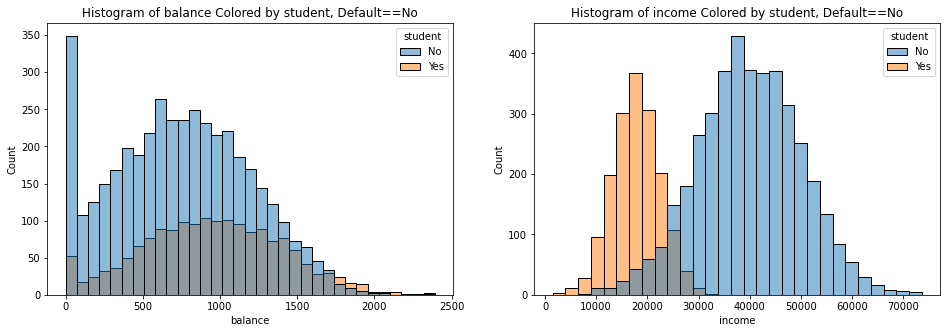

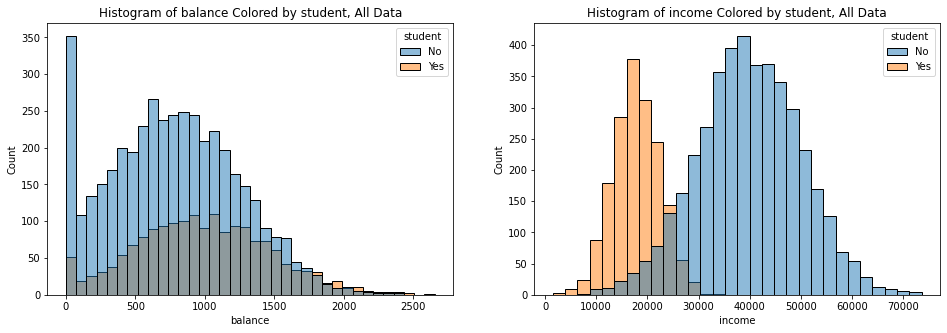

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(x='balance', data=X_train[y_train=='Yes'], hue='student', ax=ax1)
sns.histplot(x='income', data=X_train[y_train=='Yes'], hue='student', ax=ax2)
ax1.set(title='Histogram of balance Colored by student, Default==Yes')
ax2.set(title='Histogram of income Colored by student, Default==Yes')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(x='balance', data=X_train[y_train=='No'], hue='student', ax=ax1)
sns.histplot(x='income', data=X_train[y_train=='No'], hue='student', ax=ax2)
ax1.set(title='Histogram of balance Colored by student, Default==No')
ax2.set(title='Histogram of income Colored by student, Default==No')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(x='balance', data=X_train, hue='student', ax=ax1)
sns.histplot(x='income', data=X_train, hue='student', ax=ax2)
ax1.set(title='Histogram of balance Colored by student, All Data')
ax2.set(title='Histogram of income Colored by student, All Data')
plt.show()

## (b) {-}

In [3]:
from scipy.stats import norm, bernoulli
from pandas import DataFrame

dist_norm = {}
for feature in ['balance', 'income']:
    for default in ['Yes', 'No']:
        params = norm.fit(X_train[y_train==default][feature])
        dist_norm[feature + ' | ' + default] = norm(*params)
        
dist_norm['student | Yes'] = bernoulli(sum(X_train[y_train=='Yes']['student']=='Yes')/len(X_train[y_train=='Yes']))
dist_norm['student | No'] = bernoulli(sum(X_train[y_train=='No']['student']=='Yes')/len(X_train[y_train=='No']))

df = DataFrame([(k, None, *d.stats()) for k, d in dist_norm.items()], columns=['Feature|Default', 'Distribution Type', 'Mean', 'Variance'])
df['Distribution Type'] = ['Normal', 'Normal', 'Normal', 'Normal', 'Bernoulli', 'Bernoulli']
df

,Feature|Default,Distribution Type,Mean,Variance
0,balance | Yes,Normal,1718.8534899175334,127084.50907211451
1,balance | No,Normal,806.4452220460979,206827.67007859284
2,income | Yes,Normal,32128.86080803881,184822064.01256827
3,income | No,Normal,33451.150293618564,177429727.32170913
4,student | Yes,Bernoulli,0.36548223350253806,0.2319049704965343
5,student | No,Bernoulli,0.28847148026882646,0.20525568534033856


In [4]:
# prior probability of default

prior = sum(y_train=='Yes')/len(y_train)
prior

0.03283333333333333

## (c) {-}

In [5]:
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import numpy as np

def predict(X, dist, score=False):
    res = []
    for student, balance, income in X.values:
        log_pDefault = np.log(prior) \
                        + np.log(dist['student | Yes'].pmf(student=='Yes')) \
                        + np.log(dist['balance | Yes'].pdf(balance)) \
                        + np.log(dist['income | Yes'].pdf(income))
        log_pNoDefault = np.log(1-prior) \
                        + np.log(dist['student | No'].pmf(student=='Yes')) \
                        + np.log(dist['balance | No'].pdf(balance)) \
                        + np.log(dist['income | No'].pdf(income))
        
        predict_score = log_pDefault - log_pNoDefault
        res.append(predict_score if score else (predict_score > 0))
        
    return res

tn, fp, fn, tp = confusion_matrix(y_test=='Yes', predict(X_test, dist_norm)).ravel()
DataFrame([[tp, fp], [fn, tn]], columns=['True $Y$$=1$', 'True $Y$$=0$'], index=['Guess $Y$$=1$', 'Guess $Y$$=0$'])

,True $Y$$=1$,True $Y$$=0$
Guess $Y$$=1$,36,13
Guess $Y$$=0$,100,3851


In [6]:
(fn + fp)/(tn + fp + fn + tp)

0.02825

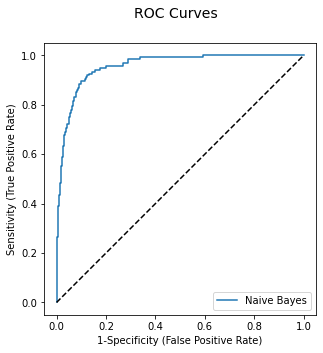

In [8]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc(dist, label):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    fpr, tpr, _ = roc_curve(y_test=='Yes', predict(X_test, dist, score=True)) 
    ax.plot(fpr, tpr, label=label)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set( aspect=1, 
            xlabel='1-Specificity (False Positive Rate)', 
            ylabel='Sensitivity (True Positive Rate)')

    fig.suptitle('ROC Curves', fontsize=14)
    plt.legend()
    plt.show()
    
plot_roc(dist_norm, 'Naive Bayes')

## (d) {-}

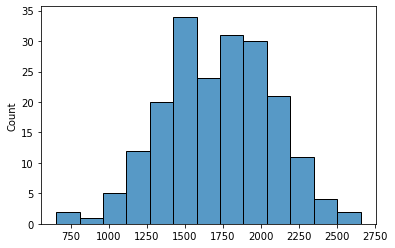

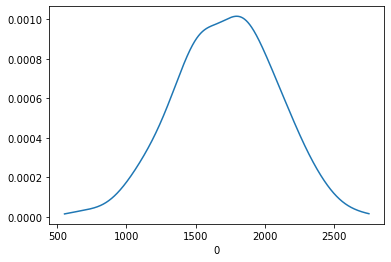

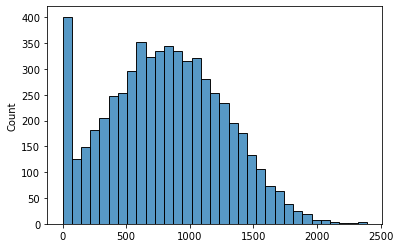

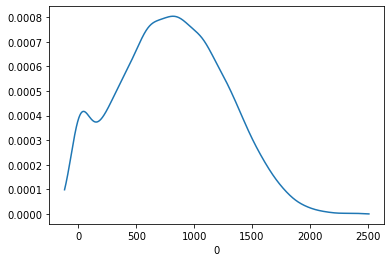

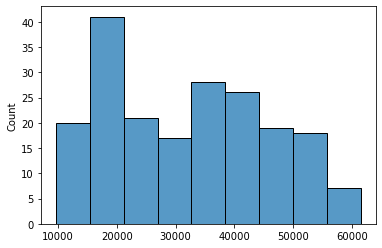

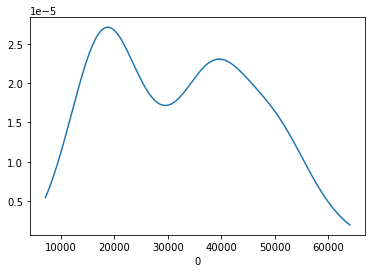

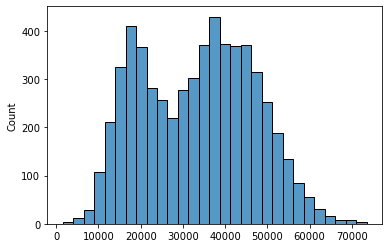

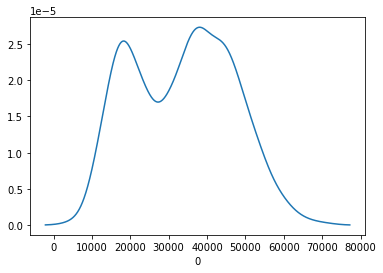

In [78]:
from scipy.stats import gaussian_kde
import seaborn as sns
from math import floor, ceil

# 不是沒有疊在一起畫只是 scale 不一樣

for feature in ['balance', 'income']:
    for default in ['Yes', 'No']:
        data = X_train[y_train==default][feature].values
        ax = sns.histplot(data)
        a, b = ax.get_xlim()
        a, b = floor(a), ceil(b)
        DataFrame(zip(range(a, b), gaussian_kde(data).pdf(range(a, b)))).set_index(0).plot(legend=None)
        plt.show()
        

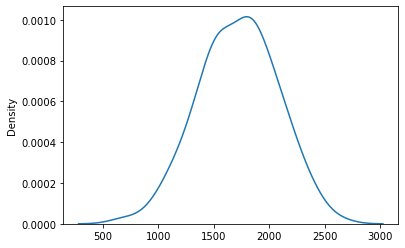

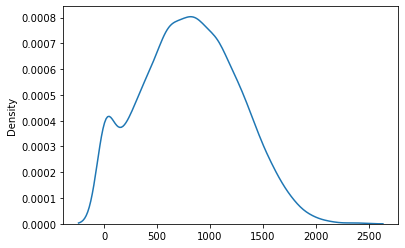

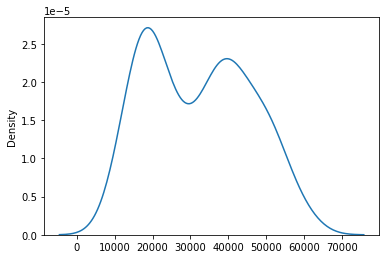

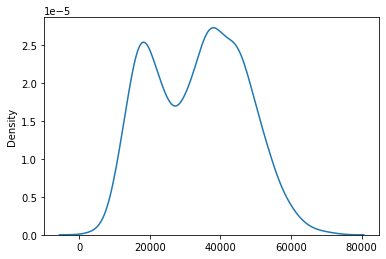

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['balance', 'income']:
    for default in ['Yes', 'No']:
        sns.kdeplot(X_train[y_train==default][feature].values)
        plt.show()
        

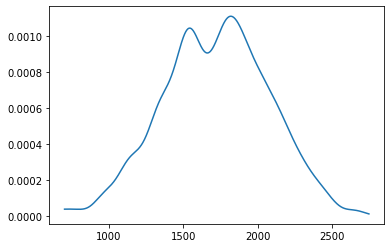

In [41]:
import seaborn as sns
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np

x = [[i] for i in range(700, 2750)]
ax = DataFrame(zip(range(700, 2750), np.exp(KernelDensity(bandwidth=70).fit(X_train[y_train=='Yes']['balance'].to_frame().values).score_samples(x)))).set_index(0).plot(legend=None)
ax.set(xlabel=None)
plt.show()

In [3]:
from scipy.stats import norm, bernoulli
from pandas import DataFrame

dist_norm = {}
for feature in ['balance', 'income']:
    for default in ['Yes', 'No']:
        params = norm.fit(X_train[y_train==default][feature])
        dist_norm[feature + ' | ' + default] = norm(*params)
        
dist_norm['student | Yes'] = bernoulli(sum(X_train[y_train=='Yes']['student']=='Yes')/len(X_train[y_train=='Yes']))
dist_norm['student | No'] = bernoulli(sum(X_train[y_train=='No']['student']=='Yes')/len(X_train[y_train=='No']))

df = DataFrame([(k, None, *d.stats()) for k, d in dist_norm.items()], columns=['Feature|Default', 'Distribution Type', 'Mean', 'Variance'])
df['Distribution Type'] = ['Normal', 'Normal', 'Normal', 'Normal', 'Bernoulli', 'Bernoulli']
df

,Feature|Default,Distribution Type,Mean,Variance
0,balance | Yes,Normal,1718.8534899175334,127084.50907211451
1,balance | No,Normal,806.4452220460979,206827.67007859284
2,income | Yes,Normal,32128.86080803881,184822064.01256827
3,income | No,Normal,33451.150293618564,177429727.32170913
4,student | Yes,Bernoulli,0.36548223350253806,0.2319049704965343
5,student | No,Bernoulli,0.28847148026882646,0.20525568534033856
